# Staring Array Modelling

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  



The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module models the signal and noise in CCD and CMOS staring array sensors.  The code is originally based on the Matlab code described in *'High-level numerical simulations of noise in solid-state photosensors: review and tutorial'* by Mikhail Konnik and James Welsh, arXiv:1412.4031v1 [astro-ph.IM], available [here](http://arxiv.org/pdf/1412.4031.pdf).

An earlier version (20161020) of a Python version of the model was presented at the Fourth SMEOS conference and was published in SPIE Proc 10036 (2016). The PDF is available here:  
https://github.com/NelisW/pyradi/blob/master/pyradi/documentation/SM200-30-staring-array-modeling.pdf

Good additional references for this work include James R Janesick's books ['Photon Transfer'](http://spie.org/Publications/Book/725073) and ['Scientific Charge-Coupled Devices'](http://spie.org/Publications/Book/374903)

This notebook provides an introduction to the model, whereas notebooks 09c and 09d provide applications of the model to visual and infrared sensors.


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import re
import os.path
from scipy.optimize import curve_fit
import datetime

from matplotlib import cm as mcm
import matplotlib.mlab as mlab
import scipy.constants as const
import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

# import xlsxwriter

import pyradi.ryplot as ryplot
import pyradi.ryfiles as ryfiles
import pyradi.rystare as rystare
import pyradi.ryutils as ryutils
import pyradi.rypflux as rypflux
import pyradi.ryplanck as ryplanck

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at stated dpi
import matplotlib as mpl
plotdpi = 72
mpl.rc("savefig", dpi=plotdpi)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

# Sensor model

## Sensor Geometry


Consider the simple sensor model depicted below.

!['images/camerascheme-horiz.png'](images/eosystem01.png)



For a detector array with $n_{\beta} \times n_{\alpha}$ detector elements, with dimensions $b$ and $a$ [m], the area of one detector element [m\textsuperscript{2}] is

\begin{equation}\label{eq:detarea}
  A_\textrm{det} = a b.
\end{equation}

The detector element field of view angles, $\beta$ and $\alpha$ [rad], in the focal plane of a sensor with a lens focal length $f$ [m], can be approximated for \textit{small linear angles} by

\begin{eqnarray}
\beta &=& \frac{b}{f} \\
  \alpha &=& \frac{a}{f},
\end{eqnarray}

with sensor pixel field of view solid angle [sr] given by

\begin{eqnarray}
\omega_\textrm{ifov} &=& \alpha \beta \nonumber \\
   &=& \frac{ab}{f^2} \nonumber \\
   & = & \frac{A_\textrm{det}}{f^2}.
\end{eqnarray}

The detector array total field of view solid angle is

\begin{equation}
\Omega  =  n_{\alpha}  n_{\beta} \omega_\textrm{ifov}.
\end{equation}


!['images/camerascheme-horiz.png'](images/cassegrain.png)


The figure above  shows the layout of a Cassegrain telescope.  In the following derivation the diameter of the entrance pupil is the outer diameter of the aperture, irrespective of the size of the central obscuration.  The diameter of the obscuration is the inner diameter of the clear aperture. It is assumed that the sensor is focussed at infinity.

For focus at infinite conjugates, the entrance pupil diameter $D_\textrm{pupil}$ [m] and clear aperture area $A_\textrm{pupil} $ [m\textsuperscript{2}] are described in terms of the F-number of the optics, $F_{\#}$ , and detector size as
\begin{eqnarray}
D_\textrm{pupil} & = & \frac{f}{F_{\#}} \\
A_\textrm{pupil} & = & \pi  \left( \frac{D_\textrm{pupil} }{2} \right) ^2 \nonumber \\
 & = & \frac{ \pi  f^2 }{4 F_{\#}^2 } \nonumber \\
 & = & \frac{\pi  a b}{4 \omega_\textrm{ifov} F_{\#}^2}.
\end{eqnarray}

The central obscuration area is expressed as a fraction $r_\textrm{central}$ of the entrance pupil diameter
\begin{eqnarray}
D_\textrm{obs}& = & r_\textrm{central}D_\textrm{pupil}\\
A_\textrm{obs}& = & \pi  \left( \frac{D_\textrm{obs} }{2} \right) ^2. \label{simopte}
\end{eqnarray}

The flux collecting area, i.e., the nominal clear aperture area, is calculated as
\begin{equation}
A_\textrm{clear}  =   A_\textrm{pupil}   -  A_\textrm{obs}. \label{eq:energycollectingarea}
\end{equation}



!['images/camerascheme-horiz.png'](images/RadiometrySolidAngles.png)

The (rotationally symmetrical) solid angles in the sensor are shown in Figure~\ref{fig:RadiometrySolidAngles}, where
$\omega_\textrm{cold shield}=\Omega_\textrm{cold shield}$ is the detector cold shield solid angle,
$\omega_\textrm{inside}=\Omega_\textrm{inside}$ is the is sensor exposed inside solid angle,
$\omega_\textrm{clear}=\Omega_\textrm{clear}$ is the clear optical aperture solid angle, and
$\omega_\textrm{obs}=\Omega_\textrm{obscured}$ is the central obscuration solid angle.
The sum of all the solid angles is equal to the projected hemispherical solid angle
\begin{equation}
\pi = \omega_\textrm{cold shield} + \omega_\textrm{inside} + \omega_\textrm{clear}+ \omega_\textrm{obs}
\end{equation}

The obscuration solid angle is given by
\begin{eqnarray}
\omega_\textrm{obs} &=&
\pi\sin^2(\Theta_\textrm{obs})\\
&=&
\pi\sin^2\left(\tan^{-1}\left[\frac{D_\textrm{obs}}{2f}\right]\right),
\end{eqnarray}

where
$\Theta_\textrm{obs}$ is the half apex angle of the obscuration f-cone.

The nominal clear aperture  solid angle is given by
\begin{eqnarray}
\omega_\textrm{clear} &=&
\pi\sin^2(\Theta_\textrm{pupil})
-
\pi\sin^2(\Theta_\textrm{obs})\\
&=&
\pi\sin^2\left(\tan^{-1}\left[\frac{D_\textrm{pupil}}{2f}\right]\right)
-
\omega_\textrm{obs},
\end{eqnarray}
where
$\Theta_\textrm{pupil}$ is the half apex angle of the aperture f-cone.

The cold shield solid angle is calculated from the detector cold shield F-number $\omega_\textrm{Fcone}=\pi\sin^2\theta^\prime$
\begin{equation}
\omega_\textrm{cold shield}
= \pi - \omega_\textrm{Fcone}
= \pi \left(1-\sin^2\theta^\prime\right)
= \pi \left(1-\frac{1}{4F^2_{\#\textrm{det}}}\right)
\end{equation}
It is assumed that the detector F-number is the same for all spectral bands.

For a detector  with a cold shield efficiency different from 100\%, i.e., the detector cold shield  $F_{\#}$ is smaller than the optics $F_{\#}$, $\omega_\textrm{inside}$ can be calculated as
\begin{eqnarray}
\omega_\textrm{inside}& = &  \pi - \omega_\textrm{clear}- \omega_\textrm{cold shield}-\omega_\textrm{obs}\\
&=&
\pi - \omega_\textrm{clear} - \pi \left(1-\frac{1}{4F^2_{\#\textrm{det}}}\right)-\omega_\textrm{obs}\\
&=&
\frac{\pi}{4F^2_{\#\textrm{det}}} - (\omega_\textrm{clear}  + \omega_\textrm{obs})\\
&=&
\frac{\pi}{4F^2_{\#\textrm{det}}} - \frac{\pi}{4F^2_{\#\textrm{optics}}}
\label{omegaoutcooled}
\end{eqnarray}


A 100\% effective cold shield, $\omega_\textrm{inside}=0$, can also be simulated by setting the sensor inside emissivity to 0 so that no radiation is coming from the sensor inside irrespective of the two solid angle values.

If the detector cold shield solid angle is smaller than the optics solid angle, the cold shield will vignet and the optics F-number is set equal to the cold shield F-number.

An uncooled detector cold shield must be modelled by setting the F-number to 0.5.



The high resolution image is normally created in higher resolution than the required sensor image resolution to allow for modelling of optical defects and sensor effects in the sensor model, refer to Figure~\ref{fig:imageconventions}. The high resolution image field of view is therefore determined by

\begin{itemize}
  \item the sensor instantaneous field of view, $\beta$ and $\alpha$,
  \item the number of detector elements, $n_{\beta}$ and $n_{\alpha}$,
  \item the number of high resolution pixels used to create one sensor pixel, $m_{\beta}$ and $m_{\alpha}$.
\end{itemize}

The high resolution image size is $m_{\beta} n_{\beta} \times m_{\alpha} n_{\alpha}$ pixels with instantaneous field of view calculated as

\begin{eqnarray}
\beta_\textrm{h} &=& \beta / m_{\beta}  \\
\alpha_\textrm{h} &=& \alpha / m_{\alpha}.
\end{eqnarray}

The high resolution image field of view linear angles in the vertical and horizontal directions are

\begin{eqnarray}
\theta_{\beta_\textrm{h}} &=& m_{\beta} n_{\beta} \beta_\textrm{h} = n_{\beta} \beta \\
\theta_{\alpha_\textrm{h}} &=& m_{\alpha} n_{\alpha} \alpha_\textrm{h} =  n_{\alpha} \alpha.
\end{eqnarray}

A field of view expansion factor, $f_\textrm{exp}$, is used to expand the field of view of the high resolution image to allow for gimbal and missile movement in the high resolution image between image builds. The expansion is also required when convolution with an \ac{OPSF} is used. The slightly larger high resolution image provides for a valid convolution process on the edges of the image.
The high resolution image field of view field linear angles are then $f_\textrm{exp}\theta_{\beta_\textrm{h}}$ and $f_\textrm{exp}\theta_{\alpha_\textrm{h}}$.



##  Scene Irradiance at the Optical Aperture

The radiance from the scene in a pixel of the high resolution image includes components reflected from the object, i.e., diffuse ($L_\textrm{sun\_d}$) and specular reflected ($L_\textrm{sun\_s}$) sun, environmental radiance ($L_\textrm{env}$) from the terrain and the sky, as well as the radiance emitted ($L_\textrm{self}$) by the object in the pixel field of view, the background radiance transmitted ($L_\textrm{back}$) through partially transparent objects and the atmospheric path radiance ($L_\textrm{path}$). Accurate radiometric radiance [W/m\textsuperscript{2}sr] for each pixel in the high resolution image is calculated using the rendering equation described in the Modelling Report \cite[Equation~\ref{MR0802-eq:rendering}]{ossimModellingReport2016}:


\begin{displaymath}
L_\textrm{scene} =
L_\textrm{self} +
L_\textrm{path} +
L_\textrm{back} +
 (
  L_\textrm{env} +
  L_\textrm{sun\_d} +
  L_\textrm{sun\_s}) ,
\end{displaymath}

where


\begin{displaymath}
L_\textrm{env} =
  L_\textrm{sky} +
  L_\textrm{terrain\_emit} +
  L_\textrm{terrain\_refl}.
\end{displaymath}


All the components in the above equation are calculated by the high resolution image renderer and are described in detail in \cite[Chapter~\ref{MR0800-sec:radiometry}]{ossimModellingReport2016}.

The high resolution image pixels are filled with the irradiance [W/m\textsuperscript{2}] at the optical aperture

\begin{equation}
  E_\textrm{scene} = \alpha_\textrm{h} \beta_\textrm{h} L_{\rm scene}. \label{eq:Ehiresscene}
\end{equation}

This irradiance is valid for the high resolution image pixel solid angle and for a normalised spectral system response. In the sensor model, optical aperture irradiance is collected from the high resolution image by summation of the irradiance of the high resolution pixels in one sensor pixel

\begin{equation}
E_\textrm{e-optics}=  {\cal S}_{\textrm{system peak}} \sum^{m_{\beta}}_{i=0} \sum^{m_{\alpha}}_{j=0}  E_{\textrm{scene}_{ij}}. \label{eq:irrpupil1}
\end{equation}


The \ac{OPSF} is defined as the response of an optical system to a point source of light. The response of the system can be written directly as the convolution of the spatial distribution and the point spread function. If an  \ac{OPSF} is modelled, convolution with the \ac{OPSF} kernel is included in Equation~\ref{eq:irrpupil1}.


### FPA Sensor model

A comprehensive CCD and CMOS staring array sensor model is provided in the pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module. The [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) model is originally based on the Matlab code described in *'High-level numerical simulations of noise in solid-state photosensors: review and tutorial'* by Mikhail Konnik and James Welsh, arXiv:1412.4031v1 [astro-ph.IM], available [here](http://arxiv.org/pdf/1412.4031.pdf). Good references for this work include James R Janesick's books ['Photon Transfer'](http://spie.org/Publications/Book/725073) and ['Scientific Charge-Coupled Devices'](http://spie.org/Publications/Book/374903).  Konnik's model is also implemented in Python as described in  notebook 09b of this series, available here: \url{http://nbviewer.jupyter.org/github/NelisW/ComputationalRadiometry/blob/master/09b-StaringArrayDetectors.ipynb}

!['images/sensenode02.png'](images/sensenode02.png)

Modern digital \ac{FPA} detectors employ (Figure above adapted from \cite{Murray2011})
\begin{enumerate}
  \item an array of detectors to capture the photons and convert them to electrons, and
  \item a \ac{ROIC} to transform the detector signal into a serial data stream.
\end{enumerate}
Both these topics will be exploed in more detail below.




As is evident in the rystare model block diagram, the model covers only the sensor signal path, including noise, signal integration and signal conditioning (photon signal generation is not part of this model).
The components of the rystare model are shown below:

!['images/camerascheme-horiz.png'](images/camerascheme-horiz.png)

The rystare model is used as a reference for this model, there is not a one-to-one mapping between elements of the two models.

!['images/sensenode01.png'](images/sensenode01.png)

The figure above shows a simplified diagram illustrating typical \ac{FPA} processing. Real devices have much more complicated circuitry, containing patented techniques.  The photoelectron current is integrated in the charge well capacitor for a specified integration time period $t_\textrm{int}$ (synchronized with the data clock).  The charge well capacitor may or may not be the actual detector junction capacitance.  The charge well capacitor ($C$) accumulates charges, but in the process also provides a voltage ($V$) signal proportional to the charge ($Q$), by $Q=CV$, hence $V=Q/C$.  The charge well capacitance exists in a semiconductor device and hence the capacitance depends on the voltage across the capacitor: the transfer function from charge to voltage may therefore be nonlinear $V=Q/C(V)$ in some devices.
The charge well has a finite charge capacity, constrained by the well capacitance and the allowable maximum signal voltage range.
Prior to the integration time start the charge well capacitor is reset to a nonzero reference voltage $V_\textrm{Ref}$ (a value around 2 to 3~V), and during integration the capacitor is discharged from $V_\textrm{Ref}$ to some lower value closer to zero.  The signal is the change in voltage from the initial $V_\textrm{Ref}$.  The  \ac{CDS} circuit employs two \ac{SHA} circuits to eliminate pixel-to-pixel reference voltage offset differences.
During pixel value reset, prior to the integration period, the first  \ac{SHA} samples the pixel reset voltage.  The second  \ac{SHA} samples the pixel voltage after integration.  The \ac{CDS} circuit measures the difference between the two  \ac{SHA}s, thereby removing the effect of $V_\textrm{Ref}$ differences  between pixels.


The model accepts an input image in photon rate [q/s)] \emph{in the detector plane} and then proceeds to calculate the various noise components and signal components along the signal flow chain. The signal chain is depicted in Figure~\ref{fig:Sensormodelelements}.  The captured photoelectron charge in the detector is determined by the flux on the detector and integration time. The photoelectron charge is converted to a voltage in the sense node, is further processed and finally converted to a digital count.
The software exports the various intermediate image planes as shown in Figure~\ref{fig:Sensormodelelements} in a telemetry file, see Section~\ref{sec:photonsetup}.

Many noise sources contribute to the resulting noise image produced by the sensor. Noise sources can be broadly classified as either \emph{fixed-pattern} (spatially stable, time invariant) or \emph{temporal} (time-variant) noise. Fixed-pattern noise refers to any spatial pattern that does not change significantly from frame to frame. Temporal noise, on the other hand, changes from one frame to the next. All these noise sources are modelled in various blocks in the signal chain.  Different noise sources have different noise statistics. Noise power from multiple uncorrelated noise sources adds in quadrature (noise variance adds linearly).  However, at specific moments in time the instantaneous (sampled) noise magnitudes add linearly with the signal to yield the total signal at that instant.



The model includes photon noise and fixed pattern non-uniformity noise.  However for low light level work a more comprehensive noise model, such as Konnik's model, is required.
The components of the noise model include 

1. Photon signal noise.
2. Detector response non-uniformity.
3. Dark current shot noise.
4. Fixed pattern dark current noise.
5. Read noise also known as kTC reset noise.
6. Source follower noise.
7. Quantisation noise.

If the magnitudes of these noise components are not available, we can just assume zero values to ignore these.

The various noise sources are assumed non-correlated and add in quadrature (with apropriate gain scaling).


### Photon noise 

Photon noise for a flux signal is given by the square root of the signal photon count.  The signal photon count comprises photons from the scene (target and background temperatures assumed to the more or less the same), photons from inside the sensor such as hot optics (other sources ignored for now), and atmosperic path radiance.   On the assumption that the atmospheric path temperature is close to the scene temperature the path radiance plus attenuated scene radiance would be more or less equal to the unattenuated scene radiance, i.e., $L_\textrm{path} + \tau_\textrm{path} L_\textrm{scene}\approx L_\textrm{scene}$.

Photon noise is casused by the photon signal itself.  The photon signal in the detector comprises the following components:

1. Reflected incident light such as sunlight, sky light or night light.
1. Thermal self-emission.
1. Path radiance
1. Stray light and internal sensor flux sources.

The total photon flux is
\begin{equation}
n_{\textrm{photons}} = n_{\textrm{scene}} +n_{\textrm{path}} + n_{\textrm{optics}}
\end{equation}

The photon noise is then 

\begin{equation}
n_{\textrm{photnoise}} =\sqrt{n_{\textrm{photons}}} =  \sqrt{n_{\textrm{scene}} +n_{\textrm{path}}+ n_{\textrm{optics}}}
\end{equation}

### Non-uniformity noise

Expanding on the signal equation developed above, the general form for the pixel well fill signal can be extended to add dark noise, the $\cos^n$ effect, and the narcissism effect
\begin{equation}
n_{\textrm{pixel}}
=
\left(\frac{\pi\,t_{\textrm{int}}\, P\, \cos^n(\theta) \,A_d }{4\,F_\#^2}
\right)
\int_0^\infty 
(\eta_{\lambda}\, \tau_{o\lambda}\, \tau_{f\lambda}\,\tau_{a\lambda})\,
\left[
L_{\lambda\textrm{signal}}+L_{\lambda\textrm{narc}}(\theta)\right]\,
d\lambda 
+n_\textrm{dark}
\end{equation}
where 
$L_{\lambda\textrm{signal}}$ is understood to include all terms of the scene flux, including reflected flux, self-emitted flux, and optics flux (excluding narcissism), and path radiance, 
$L_{\lambda\textrm{narc}}(\theta)$ is the optics' narcissism radiance (assumed a function of field angle only, but this is not always the case), 
$\cos^n\theta$ is the variation of flux as function of field angle $\theta$,
and
$n_\textrm{dark}$ is the dark current electrons accumulated during the integration time.

The field angle variation is commonly known as the `cos-to-the-fourth' rule. Note, that $n$ is not always 4, it depends on the target orientation and size. For a flat focal plane $n$ is at least 2, but possibly larger.

The optics radiance is generally modelled by a source at the sensor internal temperature and emissivity of $(1-\tau_\textrm{optics})$.  If there is no narcissism the model is nominally valid on the assumption that the reflected component reflects the internal hardware of the sensor.  If there is narcissism, some of this reflection will be from the cold detector and the assumption of a uniform internal sensor temperature is violated.

Signal spatial nonuniformity variations can be introduced by variations between detector elements in mainly the following (1) nonspectral variations such as the $A_d$ area and $\cos^n\theta$, (2) $\eta_\lambda$ quantum efficiency, (3) the narcissus effect, and (4) dark current $n_\textrm{dark}$. It is evident that is quite challenge to develop a nonuniformity correction method that can correct for the combined multidimensional variation space.

The $\cos^n\theta$ and narcissus are `large-scale' spatially correlated effects and are not considered here on the premise that it can be removed by signal processing means. The remaining uncorrelated pixel-level spatial nonuniformity effects are then:

1. Nonspectral: mainly attributable to variations in area of the active detector and area of the charge well capacitor, and to a lesser extent differences in integration time.

2. Spectral: variations in the detector material quantum efficiency across the surface of the device.  The quantum efficiency variations are smaller in stable alloys such as InSb, but could to be larger in variable mix ternary alloys such as HgCdTe.

3. Dark noise: variations in detector current in the absence of any incident flux.  In the shorter wavelength bands this simply means covering the detector, but in the thermal bands it means presenting a (near) zero kelvin background (viewing a 77 K liquid nitrogen surface is generally sufficient for cameras observing scenes at 300 K).



A detailed description of the contributors to nonuniformity is given by Black, summarised here as follows:

1. Detector area variation resulting from imperfect manufacturing.

2. Material substrate doping variation.

3. Leaky detector pixel elements with excessive dark current.

4. 1/f noise from various sources: detector, electronics, and system sources.

5. Charge transfer efficiency in CCD focal planes.

6. Nonidentical pixels, resulting from the design process.

7. Dust

8. Surface variations.

9. Multiplexer threshold or ohmic variations between channels.

10. Interlace imbalance.

11. Multiple output port imbalances.

12. Device temperature variations.

13. $\cos^n$ shading.

14. Vignetting.

15. Calibration source surface irregularities.
    

Following Mooney's derivation, simplify the above equation modelling the pixel electron count  for pixel $ij$ results in

\begin{equation}
n_{ij} = R_{ij}
\int_0^\infty 
L_{\lambda ij}\eta_{\lambda ij} d\lambda
+D_{ij}
\end{equation}

Define the variational elements in terms of an average value $\langle X_{ij}\rangle $ plus a variation $x_{ij}$:

\begin{equation}
D_{ij} = \langle D_{ij}\rangle  + d_{ij}
\end{equation}

\begin{equation}
R_{ij} = \langle R_{ij}\rangle  + r_{ij}
\end{equation}

\begin{equation}
\eta_{\lambda ij} = \langle \eta_{\lambda ij}\rangle  + k_{\lambda ij}
\end{equation}

where $d_{ij}$, $r_{ij}$, and $k_{\lambda ij}$ has zero mean on spatial average and only the spectral nonuniformities  are accounted for in $k_{\lambda ij}$
\begin{equation}
\int_0^\infty k_{\lambda ij} d\lambda = 0
\end{equation}

When observing a uniform scene $L_{\lambda ij}=L_\lambda$ and then

\begin{equation}
\langle n_{ij}\rangle  = \langle R_{ij}\rangle
\int_0^\infty
\langle \eta_{\lambda ij}\rangle L_{\lambda}  d\lambda
+\langle D_{ij}\rangle 
\end{equation}

Manipulating the above equations results in the equation describing pixel $ij$ value as

\begin{equation}
n_{ij} =
\langle n_{ij}\rangle  +
d_{ij} +
 \frac{r_{ij}[\langle n_{ij}\rangle  - \langle D_{ij}\rangle ]}{\langle R_{ij}\rangle } +
 \langle R_{ij}\rangle \int_0^\infty k_{\lambda ij} L_{\lambda}  d\lambda
\end{equation} 
With $\langle R_{ij}\rangle$ as the average value of the instrument transfer function, $\langle R_{ij}\rangle \int_0^\infty k_{\lambda ij} L_{\lambda}  d\lambda =\int_0^\infty k_{\lambda ij} n_{\lambda ij}  d\lambda$
where $n_{\lambda ij}$ is the photoelectrons produced when viewing the scene with radiance $L_{\lambda}$.

The variance in $n_{ij}$ is then given by
\begin{eqnarray}
\sigma_u^2 &=&
\sigma_d^2
+
 \frac{\sigma_r^2[\langle n_{ij}\rangle  - \langle D_{ij}\rangle ]^2}{\langle R_{ij}\rangle^2 } +
 \langle R_{ij}\rangle^2\left\langle \left[ \int_0^\infty
 k_{\lambda ij} L_{\lambda}  d\lambda\right]^2\right\rangle\\
&=&
\sigma_d^2
+
 \frac{\sigma_r^2[\langle n_{ij}\rangle  - \langle D_{ij}\rangle ]^2}{\langle R_{ij}\rangle^2 } +
\left\langle \left[ \int_0^\infty
 k_{\lambda ij} n_{\lambda ij}  d\lambda\right]^2\right\rangle
\end{eqnarray} 



In this equation  

- $\sigma_u^2$ represents the nonuniformity image variance (square of the rms value).
- $\sigma_d^2$ is the noise variance in the dark current.
- $\sigma_r^2$ is the tolerance variance in detector area-related characteristics.
- $\left\langle \left[ \int_0^\infty k_{\lambda ij} L_{\lambda}  d\lambda\right]^2\right\rangle$ (say $\sigma_l^2$) is the apparent radiance variance resulting from variations in quantum efficiency.
- $r\sigma_l=\sigma_n$.
- $\langle n_{ij}\rangle$ (a constant, say $n$) is the mean pixel value over all the pixels in the image (the expected signal).
- $\langle D_{ij}\rangle$ (a constant, say $d$)  is the dark current average over all pixels, and 
- $\langle R_{ij}\rangle$ (a constant, say $r$)  is the signal transfer function (converting radiance on the detector surface to electrons in the charge well) over all pixels.



The signal (electron count) variance equation can then be written as
\begin{eqnarray}
\sigma_u^2 
&=&
\sigma_d^2 +
\left(\frac{\sigma_r^2}{r^2}\right)\left(n  - d\right) +
 r^2 \sigma_l^2\\
&=&
\sigma_d^2 +
\left(\frac{\sigma_r^2}{r^2}\right)\left(n  - d\right) +
\sigma_n^2
\end{eqnarray} 


The fraction $\left(\frac{\sigma_r^2}{r^2}\right)$ can be interpreted as a normalised or  percentage ratio in variation of detector area (or area related characteristics). 

The dark current variance $\sigma_d^2$ can be measured in the laboratory under zero (low) incident flux conditions, then $(n-d)\rightarrow 0$ and $\sigma_l\rightarrow 0$.

The quantum efficiency variance $\sigma_l^2$ may be estimated under high flux conditions, $n>d$ and $\sigma_d^2\ll$, if $\sigma_r^2$ can be determined by some other nonradiometric means. Perhaps (hypothesis not tested) it can be determined by 
using a number of flux levels.

This equation may be further simplified under certain assumptions:

1. *Low light, visible spectral band* operation:  no simplification is possible because the signal $n$ is small compared to the dark signal. 

2. Under *large photon signal  conditions*: $\sigma_d^2\ll$ and it can be ignored, also $n\gg d$, then 
    \begin{equation}
    \sigma_{u_\textrm{high flux}}^2 =
    \frac{\sigma_r^2}{r^2}n +
     \sigma_n^2
    \end{equation}  

3.  Under *large photon signal conditions* and if the *quantum efficiency is uniform*, $\sigma_l^2=\sigma_n^2=0$, then
    \begin{equation}
    \sigma^2_{u} = \frac{\sigma_r^2}{r^2}n 
    \end{equation}  

4.  If there is no/small area variations $\sigma_r^2\rightarrow 0$, but with low light flux $\sigma_d^2\leq  \sigma_n^2$
    \begin{equation}
    \sigma_u^2 =
    \sigma_d^2 +
     \sigma_n^2
    \end{equation}  

5.  If there is no/small area variations $\sigma_r^2\rightarrow 0$, as well as high flux  $\sigma_d^2 < \sigma_n^2$
    \begin{equation}
    \sigma_u^2 =
     \sigma_n^2
    \end{equation} 
    
    
    

Large signal photon conditions occur for high flux signals in the visible band (large numbers of photons).
Large signal photon conditions always apply in the thermal bands (large numbers of low energy photons).

A commonly found metric for visual CCD and CMOS sensors is the $U$ value relating the nonuniformity noise standard deviation
$n_{\textrm{NU}}$ with the signal flux: $\sigma_u = n_{\textrm{NU}}=U n_{\textrm{photoelectrons}}$.  Typical values for $U$ are less than or equal to  1% for CCD and 5% for CMOS sensors.  This corresponds with approximation 5 above, assuming high flux signal conditions and with zero variance in detector area.  Under low light conditions this approximation is not valid.

Holst describes infrared sensor nonuniformity noise variance as having the form $\sigma_u = n_{\textrm{NU}}=U n_{\textrm{photoelectrons}}$. This also corresponds with approximation 5 above, assuming high flux signal conditions and with zero variance in detector area.  The high flux condition is alway valid for sensors operating in the thermal spectral bands.

According to Janesick (p169) the dark current nonuniformity standard deviation is around 10% (CCD) and 40% (CMOS) of the the dark current (for silicon detectors). Note that dark nonuniformity $\sigma_d$ is much greater than light nonuniformity $\sigma_n$ by approximately 10-40 times.




Mooney points out that it is impossible to achieve perfect nonuniformity correction however complex algorithm may be used. His analysis shows that the chromatic correction required by nonzero $k_{\lambda ij}$ depends on the knowledge of the spectral radiance on the detector. In general the exact spectral radiance is not known or even predictable: visual band the target spectral reflection greatly modifies the solar spectral radiance. In the 3--5 $\mu$m spectral band the signature comprises reflected solar flux and self-emitted thermal flux, the exact ratio of which is not predictable.

The final version of the model is then

\begin{equation}
\sigma_u^2 =
\sigma_d^2 +
\left(\frac{\sigma_r^2}{r^2}\right)\left(n  - d\right) +
\sigma_n^2
\end{equation} 

with the following **estimated** values (please substitute your own, better estimates):

1.  $\sigma_d=U_d\,n_\textrm{photon}$  where $U_d$ is 10 to 40% of the dark current $n_{\textrm{darkcurrent}}$ (see below), for  all sensors.

1. $\sigma_r$ = 0, on the assumption that the detector area-related variations are well controlled, and also that for low flux levels $\sigma_r^2\left(n  - d\right)\rightarrow 0$.

1. $\sigma_n=U\,n_\textrm{photon}$, where $U$ is 1% (CCD) to 5% (CMOS) for sensors operating in the visual band.  Infrared cameras can have nonuniformity $U$ as high as 25%, and require active correction.  It can be assumed that for infrared cameras with nonuniformity correction will have 
$\sigma_n\leq 0.4\sigma_\textrm{tvh}$ where $\sigma_\textrm{tvh}$ is the total noise in the sensor.

### Dark current shot noise

Dark noise is the current flowing in a detector with no photon incidence, resulting from many different processes in a detector\cite{Kinch2007,Janesick2007}. Sources of dark current include (depending on the material and operating temperature): thermal diffusion current, thermal generation and tunneling through bandgap states in the depletion region, and surface current\cite{Kinch2007}. It appears that fill factor does not apply to dark current.  Combining information from several sources\cite{Kinch2007,Janesick2007,raptorninoxwhitepaper2016}
the following model for the mean dark current is used (noting that for silicon $\sqrt{E_\textrm{gap}}\approx 1$):

\begin{equation}
n_{8} = n_{\textrm{darkcurrent}} = \frac{ 2.55\times10^{15}t_\textrm{int} A_d D_{FM} T^{1.5} }{\sqrt{E_\textrm{gap}}} \cdot
\left[\exp\left(-\frac{E_\textrm{gap}}{c_m k T}\right)\right]
\end{equation}
where the material band gap $E_\textrm{gap}$ temperature variation is approximated by the Varshni model
\begin{equation}
E_\textrm{gap}(T) = E_\textrm{gap0} - \frac{AT^2}{T+B}
\end{equation}
and
$t_\textrm{int}$ is the integration time,
$A_d$ is the pixel's area [cm$^2$],
$D_{FM}$ is the detector dark current figure-of-merit at 300~K (varies significantly
with sensor manufacturer),
$T$ is temperature [K],
$k$ is Boltzman's constant [eV/K], and the rest of the equation coefficients are defined for different detector materials in the table below:


The dark current carriers create a temporal electron count shot noise with  variance $\sigma^2_\textrm{dark} = n_\textrm{darkcurrent}$.  The dark current noise is random over subsequent image frames.


The spatial dark current noise generation process is random around a mean value (Equation~\ref{eq:darkcurrent}), spatially across different pixels but not across subsequent image frames for the same pixels. The  fixed spatial structure is called the dark current fixed pattern noise (DFPN).  The spatial pattern for dark noise generation is not the same as the PRNU for photoelectron generation (Section~\ref{sec:Detectorfixedpatternnoise}), it is caused by different processes, has a different statistical nature, and has much wider variation.  Konnik\cite{Konnik2014} argues a model that uses a lognormal probability distribution combined with one or more probability distributions.  His model is verified using experimental work on astronomical cameras, requiring really long integration times.  For the present model, only a single lognormal distribution is used (instead of a normal distribution) to obtain the required `outlier' or 'hot' noisy dark pixels:
\begin{equation}
n_\textrm{11} = n_\textrm{9}\left[1+\log\mathcal{N}(0,\sigma^2_\textrm{DNU})\right]
\end{equation}
where
$\log\mathcal{N}(0,\sigma^2_\textrm{DNU})$ is a lognormal probability distribution with mean value of zero and variance of $\sigma^2_\textrm{DNU}$, and the dark current nonuniformity $\sigma_\textrm{DNU}$ is between 0.1 and 0.4 for silicon detectors\cite{Janesick2007} and assumed similar for other detector types.

It is evident that, for the values used here, the dark current noise is insignificantly small and will be ignored.


### Read noise also known as kTC reset noise

kTC noise results from random fluctuations of charge on the sense node during the reset stage, resulting in a corresponding photodiode reset voltage fluctuation.   In CCD sensors the sense node reset noise is removed by Correlated Double Sampling (CDS).
In CMOS photosensors, it is difficult to remove the reset noise even after application of CDS. Specifically, the difficulties arise in 'rolling shutter' and 'snap' readout modes.  Elimination of reset noise in CMOS is quite challenging.
The magnitude of the sense node read noise in electrons is given by 

\begin{equation}
n_{\textrm{kTCnoise}}=\frac{\sqrt{k_B T C_{SN}}}{q}
\end{equation}

where
$q$ is the charge of an electron,
$k_B$ is the Boltzmann constant, 
$T$ is the temperature, and 
$C_{SN}$ is the sense node capacitance.
For this investigation the noise is assumed gaussian distributed.

The sense node capacitance can be determined from the sense node gain $A_\textrm{SN}$, expressed in volt per electron. From $Q=CV$ where $Q$ in this case is expressed in electron count not coulomb the sense node capacitance is $C_{SN} = \frac{q}{A_\textrm{SN}}$.
Then 

\begin{equation}
n_{\textrm{kTCnoise}}=\sqrt{\frac{k_B T }{A_\textrm{SN} q}}
\end{equation}

Typical values for the sense node gain is 5 to 150 $\mu$V/e$^-$.

### Total noise

The total noise  is then given by

\begin{equation}
n_{\textrm{noise}} = \sqrt{n_{\textrm{photnoise}}^2+ n_{\textrm{NU}}^2 + n^2_{\textrm{darkcurrentnoise}} + n^2_{\textrm{kTCnoise}}}
\end{equation}

For visual band sensors (corresponding to Equation 10 in [G])

\begin{equation}
n_{\textrm{noise}} = \sqrt{n_{\textrm{photnoise}}^2+ (U n_{\textrm{photons}})^2 + n^2_{\textrm{darkcurrentnoise}} + n^2_{\textrm{kTCnoise}}}
\end{equation}

For infrared sensors

\begin{equation}
n_{\textrm{noise}} 
= \sqrt{n_{\textrm{photnoise}}^2+ \left(\sqrt{n_{\textrm{photons}}}\right)^{-2} + n^2_{\textrm{darkcurrentnoise}} + n^2_{\textrm{kTCnoise}}}
\end{equation}

\begin{equation}
n_{\textrm{noise}} 
= \sqrt{n_{\textrm{photons}}+ n_{\textrm{photons}}^{-1} + n^2_{\textrm{darkcurrentnoise}} + n^2_{\textrm{kTCnoise}}}
\end{equation}



## Charge conversion nonlinearity

If the sense node capacitor has a nonlinear voltage relationship $C_\textrm{SN}(V_\textrm{SN}) = k_1/V_\textrm{SN}$ the signal voltage has a nonlinear relationship with respect to accumulated charge.
\begin{equation}
V_\textrm{signal}= V_\textrm{Ref}\left(1-\exp\left[ \frac{- \alpha n_\textrm{13}\cdot q }{k_1} \right]\right)
\end{equation}


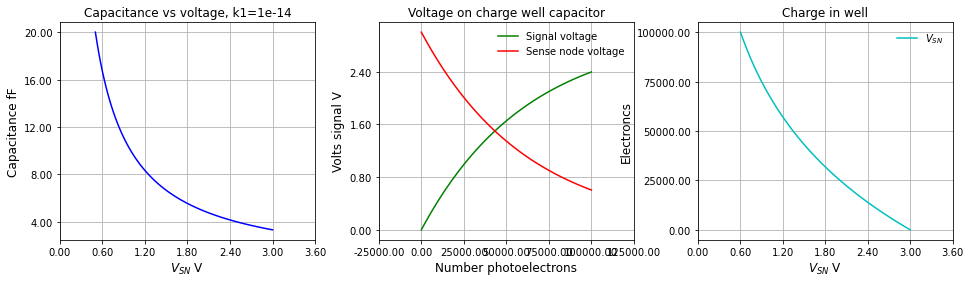

In [2]:
# to demonstrate the effect of alpha, following Janesick's Example 7.2

k1 = 10e-15
vref = 3.0
vsnmin = 0.5
nphelec = np.linspace(0,1e5,100)
vsnp = np.linspace(0.5,3,100)
p = ryplot.Plotter(1,1,3,figsize=(16,4));
p.plot(1,vsnp,1e15*k1/vsnp,'Capacitance vs voltage, k1={}'.format(k1),
       '$V_{SN}$ V','Capacitance fF');
vsignal = vref * (1.0 - np.exp(- nphelec * const.e / (k1)))
vsn = vref * (np.exp(- nphelec * const.e / (k1)))
p.plot(2,nphelec, vsignal,'Voltage on charge well capacitor','Number photoelectrons','Volts signal V',
       label=['Signal voltage'],maxNX=5);
p.plot(2,nphelec, vsn,label=['Sense node voltage'],maxNX=5);

nelec = -(k1/const.e)*np.log(vsn/vref)
p.plot(3, vsn, nelec,'Charge in well','$V_{SN}$ V','Electroncs',label=['$V_{SN}$'],maxNX=5);


## Source follower nonlinearity
 
The nonlinear source follower gain is given by 
 
\begin{equation}
A_\textrm{SFnl} =  A_\textrm{SF}\left[1 - (\gamma - 1) 
\left(\frac{V_\textrm{Ref}-V_\textrm{SN}}{V_\textrm{Ref}-V_\textrm{Full-well}}\right)
\right]
\end{equation}
where
$A_\textrm{SFnl}$ is the nonlinearised source follower gain,
$A_\textrm{SF}$ is the linear (ideal) source follower gain (close to unity),
$\gamma$ is the nonlinear error (typically 0.95 to 1.05), 
$V_\textrm{Ref}$ is the reference voltage, and 
$V_\textrm{SN}$ is the sense node voltage.

 

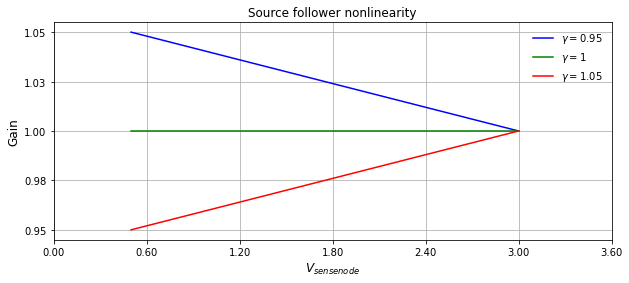

In [3]:
sfGain = 1.0
nlinratios = [0.95, 1, 1.05]
voltfullwell = 0.5
vref = 3.0
vsn = np.linspace(0.5 , 3., 100)

p = ryplot.Plotter(1,1,1, figsize=(10,4))
for nlinratio in nlinratios:
    sfgainnonlin = sfGain * (1 - (nlinratio -1.) * ((vref - vsn) /( vref- voltfullwell) ))
    p.plot(1, vsn,sfgainnonlin, 'Source follower nonlinearity','$V_{sensenode}$','Gain',
          label=['$\gamma={}$'.format(nlinratio)])

## ADC nonlinearity



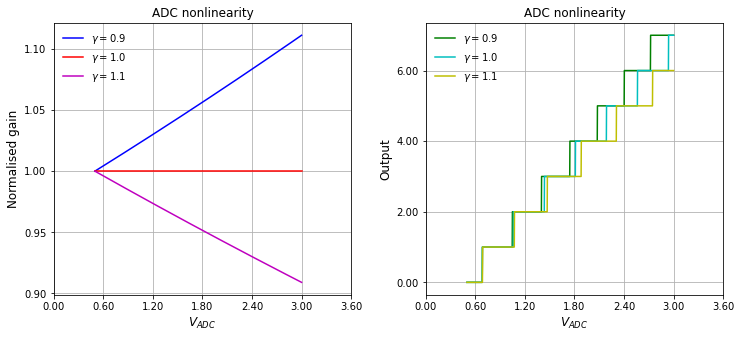

In [4]:
vadc = vref
N = 3
vres = vadc / 2 ** N
gammas = [0.9, 1., 1.1]
vinp = np.linspace(vsnmin,vadc,1000)

p = ryplot.Plotter(1,1,2,figsize=(12,5))
for gamma in gammas:
    aadc = (1/vres)**(1 - ((vinp-vsnmin)/(vadc-vsnmin))*(np.log(gamma/vres)/np.log(1./vres)-1))
    p.plot(1,vinp, vres *aadc, 'ADC nonlinearity','$V_{ADC}$','Normalised gain',label=['$\gamma={}$'.format(gamma)])
    vdigit = np.round((vinp-vsnmin)*aadc)
    
    p.plot(2,vinp, vdigit, 'ADC nonlinearity','$V_{ADC}$','Output',label=['$\gamma={}$'.format(gamma)])
    

## Read Out Technologies




The \ac{ROIC} can use either a \ac{CCD} or \ac{CMOS} technology to read out the detector signal.
Visual band sensors use silicon technology for detection and use either \ac{CCD} or \ac{CMOS} \ac{ROIC} (all functionality in a monolithic chip).
Infrared sensors use silicon \ac{CMOS} \ac{ROIC}, but one of many different detector materials.  The detector chip and \ac{ROIC} chip are interconnected most often with indium bumps on chip level (hybrid technology).

Modeling the two different \ac{ROIC} technologies require different approaches because of the inherent differences in charge and voltage processing. However, with some poetic licence and appropriate parameter selection it is possible to use a single model for high-level image simulation.  The model presented here has a hybrid \ac{CMOS}/\ac{CCD} structure, with switchable options.  \ac{CMOS} \ac{ROIC} designs have a large number of different topologies\cite{CCHCYWFWJTPS1997}, ranging from simple voltage follower at each detector (as is used in \ac{CCD} \ac{ROIC}s), \ac{DI}, \ac{BDI}, \ac{CTIA}), and \ac{GMI} circuits. Circuit complexity can range from a few transistors to many transistors per pixel (designated as e.g., 3T, 5T, etc.).
This model uses a source follower topology in order to model both \ac{CCD} and \ac{CMOS} devices.

One of the figures above presents a comparison of the commonality and differences between the \ac{CCD} and \ac{CMOS} technologies. Photon capture in the material, its conversion to electrons and the accumulation of electrons are performed by a two-dimensional array of detector devices.  Each pixel accumulates charge on a capacitor within the footprint of the detector pixel itself. \ac{CCD} and \ac{CMOS} differ in the methods used to store, move and read out the signals.  \ac{CCD} devices transfer charges along its two-dimensional structures, whereas \ac{CMOS} devices keep charges local and make voltage levels available in its two-dimensional structures.

In the case of \ac{CCD}s, the two-dimensional array of charges are transferred along one axis (say $x$) to the edge of the array, where another charge transferring mechanism moves the charges along the other axis (say $y$) via a readout node to the outside world. The \ac{CCD}'s readout node performs the charge to current conversion.  There are only a small number of readout nodes (one to eight) where this conversion takes place. Charge accumulation under each pixel, charge transfer and eventual charge conversion are all (approximately) linear processes.  There may be differences in gain and offset between the different charge transfer and conversion channels, exhibiting as spatial \ac{NU}.

In the case of \ac{CMOS}, the charges are collected in a two-dimensional array of  charge well capacitors, converted to voltages at each detector pixel, and the voltage at each pixel is read out by multiplexed switches of each detector signal to the outside world.  The charge accumulation in the \ac{CMOS} device may be nonlinear and the gain and offset variations all appear at pixel level, but there may be some spatially structured variations attributable to differences between different readout channels.





# Imager radiometry

All the following models are implemented in [pyradi.rystare.py](https://github.com/NelisW/pyradi/blob/master/pyradi/rystare.py).

## Irradiance in the focal plane and electron count in the detector

![images/sensor-diagram.png](images/sensor-diagram.png)

Consider a source at range $R_{01}$ illuminated with illumination/irradiance $E_0$ at a single wavelength.  The pixel flux is given by

\begin{equation}
\Phi_s = \frac{ L_0 A_0 A_1 \tau_a}{R_{01}^2}
\end{equation}

where the radiance $L_0$ is given by 

\begin{equation}
L_0 = \frac{E_0 \rho}{\pi}
\end{equation}

where $E_0$ is the illumination on the object, where the reflectance is assumed to be 
 lambertian,  and where $\rho$ is the diffuse source reflectance.  Then 
 
\begin{equation}
\Phi_s = \frac{ E_0 \rho A_0 A_1\tau_a}{\pi R_{01}^2}
\end{equation}

The pixel field of view is given by $A_0/R^2_{01} = A_s/f_s^2 = \Omega_p$. The sensor clear aperture area can be written in terms of f-number as $A_1 = f_s^2 \pi/(4 F_\#^2)$. Replacing in the above equation yields

\begin{equation}
\Phi_s 
= \frac{ E_0 \rho}{\pi} \frac{f_s^2 \pi }{4 F_\#^2} \Omega_p \tau_a
=  \frac{  E_0 \rho A_s \tau_a}{4 F_\#^2}  
=  \frac{\pi  L_0 \rho A_s \tau_a}{4 F_\#^2}  
\end{equation}

The irradiance in the focal plane is then 

\begin{equation}
E_s = \frac{\Phi_s }{ A_s} 
= \frac{  E_0 \rho \tau_a}{4 F_\#^2}  
= \frac{\pi  L_0 \rho \tau_a}{4 F_\#^2}  
\end{equation}

The flux passing through the detector area is $E_s\, A_d$.  If the flux is defined in terms of photons per second, the number of photons accumulated in the detector during integration time $t_{\textrm{int}}$ is  $E_s\, A_d\, t_{\textrm{int}}$.  The electron count accumulated during the integration time is then

\begin{equation}
n = \eta E_s A_d\, t_{\textrm{int}}
= \left(\frac{\eta\pi\, t_{\textrm{int}}\,P\, A_d}{4\, F_\#^2} \right) \left( \rho\, \tau_a\, L_0\right)
\end{equation}
where 
$\eta$ is the quantum efficiency, and 
$P$ is the fractional clear aperture (in case some obscuration is present).

The solid angle of the optics' f-number cone is $\Omega_{F_\#}=\pi/(4F_\#^2)$, hence the above equation can be written

\begin{equation}
n = \eta E_s A_d\, t_{\textrm{int}}
= \left(\eta t_{\textrm{int}}\,P\, A_d \Omega_{F_\#}\right) \left( \rho\, \tau_a\, L_0\right)
\end{equation}

The last two equations forms the basis for the various electron-count contributions defined below.


### Constant spectral properties

Most sensors have relatively wide spectral response and the monochromatic derivation above must be extended to calculate the sum of fluxes at all wavelengths.
The spectral integrals in the equations below have the general form

\begin{equation}
(\cdots)\,\int_0^\infty
\eta_{\lambda}\, \tau_{o\lambda}\, \tau_{f\lambda}\,\tau_{a\lambda}\, \rho_{\textrm{d}\lambda} \,
 L_{q\lambda} \,d \lambda 
\end{equation}

If a spectral variable, e.g., any or all of $(\eta_{\lambda} \, \tau_{f\lambda}\, \tau_{o\lambda}\,\tau_{a\lambda}\, \rho_{\textrm{d}\lambda})$, can be assumed constant over spectral band, they can be taken out of th integral.  If all are constant only $L_{q\lambda}$ remains in the spectral band integral
 
\begin{equation}
\eta \tau_{o} \tau_{a}  \rho_\textrm{d} 
\int_0^\infty L_{q\lambda} \;d\lambda
\end{equation}

### Photon radiance

By setting $ t_{\textrm{int}}=P=A_d=\cos\theta=\eta=\tau_{o}=\tau_{f}=\tau_{a}=\rho_\textrm{d}=\Omega_{F_\#}=1$ and $F_\#=\sqrt{\pi/4}$, the equation simplifies to the wideband photon rate radiance at the target 

\begin{equation}
L_{\textrm{q}}
=
\int_0^\infty L_{q\lambda} \;d\lambda
\end{equation}

## Photon rate model

This section considers the electron count for a variety of sources.  These equations form the basis for the library implementation that is used in the rest of the document.

### Self emitted flux

The thermal scene-radiance photon count is given by

\begin{equation}
n_{\textrm{sceneT}}
=
\left(\frac{\pi\,t_{\textrm{int}}\, P\,  A_d }{4\,F_\#^2}\right)
\int_0^\infty 
(\eta_{\lambda}\, \tau_{o\lambda}\, \tau_{f\lambda}\,\tau_{a\lambda})\,
(\epsilon_{\lambda}\, L_\lambda(T_\textrm{source}))\,
d\lambda
\end{equation}

where
$t_{\textrm{int}}$ is the integration time,
$P$ is the fraction of clear aperture, 
$A_d$ is the detector area, 
$F_\#$ is the f-number, 
$\eta_{\lambda}$ is the detector quantum efficiency,
$\tau_{o\lambda}$ is the optics transmittance, 
$\tau_{f\lambda}$ is the sensor filter transmittance, 
$\tau_{a\lambda}$ is the atmospheric transmittance, 
$\epsilon_{\lambda}$ is the source/background emissivity,and
$L_\lambda(T_\textrm{source})$ the Planck photon rate radiance at source/background temperature $T_\textrm{source}$.




### Reflected flux

The electron count in the detector can be calculated from the scene or source radiance using
 
\begin{equation}
n_{\textrm{sceneR}}
=
\left(\frac{\pi\, t_{\textrm{int}}\, P\,  A_d}{4\,F_\#^2}\right)
\cdot \cos\theta \cdot
\int_0^\infty
(\eta_{\lambda}\, \tau_{o\lambda}\, \tau_{a\lambda})\, \tau_{f\lambda}\,( \psi\rho_{\textrm{d}\lambda} \,
 L_{q\lambda}(T_\textrm{illum}) )\,
d \lambda 
\end{equation}

where
$n_{\textrm{scene}}$  is the number of electrons,
$t_{\textrm{int}}$ is the sensor integration time, 
$P$ is the fraction of unobscured optical aperture, 
$A_d$ is the area of the detector, 
$\theta$ is the angle between the surface normal vector and the primary source (if not the sun or the moon, $\theta=0$),
$F_\#$ is the f-number (assuming infinite conjugates), 
$\eta_{\lambda}$ is the detector spectral quantum efficiency, 
$\tau_{o\lambda}$ is the spectral optics and filter transmittance, 
$\tau_{\lambda}$ is the spectral atmospheric transmittance,
$\psi$ is the ratio of radiance on the illuminating source surface to radiance on the target source surface,
$\rho_{\textrm{d}\lambda}$ is the surface's diffuse spectral  reflection, 
$L_{q\lambda}$ is the spectral photon rate radiance at the surface, and
$T_\textrm{illum}$ is the temperature of the illuminating source.

If the surface is illuminated by the sun, the spectral radiance at the surface becomes
$L_{q\lambda} = \psi \epsilon_\textrm{sun}\tau_\textrm{sun}L_{q\textrm{b}}(6000 K)$,
where 
$\psi=2.17\times 10^{-5}$ relates the sun's area and distance to radiance on the ground,
$\epsilon_\textrm{sun}=1$ is the sun emissivity, 
$\tau_\textrm{sun}$  is the atmospheric transmittance from the target to the sun, and
$L_{q\textrm{b}}(6000 K)$ is the Planck-law thermal radiance for a 6000 K source (approximation of the sun's surface temperature).

### Low light radiance

The approximate low light level scene radiance levels were calculated above and stored in the `dfPhotRates` DataFrame.  These values are already integrated over the spectral bandwidth, so the scene-induced electron count in the detector becomes
 
\begin{equation}
n_{\textrm{sceneR}}
=
\left(\frac{\pi\, t_{\textrm{int}}\, P\,  A_d}{4\,F_\#^2}\right)
\cdot \cos\theta\cdot
( \eta\, \tau_{o}\, \tau_{f\lambda}\, \tau_{a})\, (\rho_\textrm{d} \,
 L_{qLL})\,
\end{equation}

where
$n_{\textrm{scene}}$  is the number of electrons,
$t_{\textrm{int}}$ is the sensor integration time, 
$P$ is the fraction of unobscured optical aperture, 
$A_d$ is the area of the detector, 
$\theta$ is the angle between the surface normal vector and the primary source (if not the sun or the moon, $\theta=0$),
$F_\#$ is the f-number, 
$\eta$ is the detector quantum efficiency, 
$\tau_{o}$ is the optics transmittance, 
$\tau_{a}$ is the atmospheric transmittance,
$\rho_\textrm{d}$ is the surface reflection, and 
$L_{qLL}$ is the photon rate radiance of the surface, as calculated above in `dfPhotRates`.


### Hot optics radiance

For infrared sensors the thermal hot-optics photon count is given by 

\begin{equation}
n_{\textrm{optics}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda}  
\, \tau_{f\lambda}(1-\tau_{o\lambda}) L_\lambda(T_\textrm{optics})
d\lambda
\end{equation}

where
the optics emissivity is given by
$\epsilon_{\textrm{optics}\lambda}=(1-\tau_{o\lambda})$.
                                          

Assuming no stray light in the visual system, the visual optics photon count is given by 

\begin{equation}
n_{\textrm{optics}}=0
\end{equation}
                                          

### Path radiance

The path radiance  photon count is given by

\begin{equation}
n_{\textrm{path}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda}  
\tau_{o\lambda}\, \tau_{f\lambda} L_{\lambda\textrm{path}}
d\lambda
\end{equation}

where $L_{\lambda\textrm{path}}$ is the path radiance.
 
Path radiance at one range can be scaled to path radiance at another range.  It can be shown that path radiance can be approximated by

\begin{equation}
L_{\lambda\textrm{path}} = L_{\lambda\textrm{path}\infty}\left(1-\tau_{\textrm{path}}\right)
\end{equation}

where
$L_{\lambda\textrm{path}\infty}$ is the path radiance for an infinitely long path where $\tau_{\textrm{path}}=0$.

If path radiance for a given path $R_1$ is known, the path radiance for a new path $R_2$can be determined by

\begin{equation}
L_{\lambda\textrm{path}}(R_2) = L_{\lambda\textrm{path}}(R_1)\left[\frac{\left(1-\tau_{\textrm{path}}(R_2)\right)}{\left(1-\tau_{\textrm{path}}(R_1)\right)}\right]
\end{equation}
 

### Complete model

The total electron count in the detector is given by the sum of all the terms defined above.  The various contributions are structured in this diagram

![images/rypflux02.png](images/rydecount02.png)

where the underlined $\underline{T}$, $\underline{A}$, and $\underline{S}$ signifies the origin of the contribution (Target, Atmosphere, and Sensor).

## Focal plane irradiance at low light levels

The photon rate radiance at low light levels is analysed in some detail in the [Optical Sources notebook](https://github.com/NelisW/ComputationalRadiometry/blob/master/07-Optical-Sources.ipynb).


### Target characteristics 

In order to benchmark the signal levels in the rest of the document, we calculate the irradiance/illumination on the detector for a target reflectance of 0.3,  an atmospheric transmittance of 0.5, optics transmittance of 0.9, and a few sensor f-numbers.

In [5]:

pf = rypflux.PFlux()
lx = pf.lllux

def calcIrrad(lx, rho, taua, tauo, fno):
    return lx * rho * taua * tauo / (4 * fno ** 2)

df = pd.DataFrame(lx).transpose()
df.columns = pf.llluxCols

rho = 0.3
taua = 0.5
tauo = 0.9
fnos = [1.4, 2, 2.74, 3.8]
for fno in fnos:
# #     http://stackoverflow.com/questions/21188504/python-pandas-apply-a-function-with-arguments-to-a-series-update
    df['{}'.format(fno)] = df['Irradiance-lm/m2'].apply(calcIrrad, args=(rho, taua, tauo, fno) )
    
df.sort_values(by='Irradiance-lm/m2',inplace=True)
print(df.drop(['FracPhotop'],axis=1))

                Irradiance-lm/m2  ColourTemp          1.4             2          2.74           3.8
Overcast night            0.0001      5000.0     0.000002  8.437500e-07  4.495445e-07  2.337258e-07
Star light                0.0011      5000.0     0.000019  9.281250e-06  4.944989e-06  2.570983e-06
Quarter moon              0.0108      4150.0     0.000186  9.112500e-05  4.855080e-05  2.524238e-05
Full moon                 0.1080      4150.0     0.001860  9.112500e-04  4.855080e-04  2.524238e-04
Deep twilight             1.0800     10000.0     0.018597  9.112500e-03  4.855080e-03  2.524238e-03
Twilight                 10.8000     10000.0     0.185969  9.112500e-02  4.855080e-02  2.524238e-02
Very dark day           107.0000      7000.0     1.842474  9.028125e-01  4.810126e-01  2.500866e-01
Overcast day           1075.0000      6000.0    18.510842  9.070312e+00  4.832603e+00  2.512552e+00
Full sky light        10752.0000     12000.0   185.142857  9.072000e+01  4.833502e+01  2.513019e+01


In [6]:
lx = pf.lllux

def calcIrrad(lx, rho, taua, tauo, fno):
    return lx * rho * taua * tauo / (4 * fno ** 2)

df = pd.DataFrame(lx).transpose()
df.columns = pf.llluxCols

rho = 0.3
taua = 0.5
tauo = 0.9
fnos = [1.4, 2, 2.74, 3.8, 5.4, 7.5, 10, 14.8, 20]
for fno in fnos:
#     http://stackoverflow.com/questions/21188504/python-pandas-apply-a-function-with-arguments-to-a-series-update
    df['{}'.format(fno)] = df['Irradiance-lm/m2'].apply(calcIrrad, args=(rho, taua, tauo, fno) )
    
df.sort_values(by='Irradiance-lm/m2')

,Irradiance-lm/m2,ColourTemp,FracPhotop,1.4,2,2.74,3.8,5.4,7.5,10,14.8,20
Overcast night,0.0001,5000.0,0.0,0.000002,8.437500e-07,4.495445e-07,2.337258e-07,1.157407e-07,6.000000e-08,3.375000e-08,1.540814e-08,8.437500e-09
Star light,0.0011,5000.0,0.2,0.000019,9.281250e-06,4.944989e-06,2.570983e-06,1.273148e-06,6.600000e-07,3.712500e-07,1.694896e-07,9.281250e-08
Quarter moon,0.0108,4150.0,0.4,0.000186,9.112500e-05,4.855080e-05,2.524238e-05,1.250000e-05,6.480000e-06,3.645000e-06,1.664080e-06,9.112500e-07
Full moon,0.1080,4150.0,0.6,0.001860,9.112500e-04,4.855080e-04,2.524238e-04,1.250000e-04,6.480000e-05,3.645000e-05,1.664080e-05,9.112500e-06
Deep twilight,1.0800,10000.0,0.8,0.018597,9.112500e-03,4.855080e-03,2.524238e-03,1.250000e-03,6.480000e-04,3.645000e-04,1.664080e-04,9.112500e-05
Twilight,10.8000,10000.0,1.0,0.185969,9.112500e-02,4.855080e-02,2.524238e-02,1.250000e-02,6.480000e-03,3.645000e-03,1.664080e-03,9.112500e-04
Very dark day,107.0000,7000.0,1.0,1.842474,9.028125e-01,4.810126e-01,2.500866e-01,1.238426e-01,6.420000e-02,3.611250e-02,1.648671e-02,9.028125e-03
Overcast day,1075.0000,6000.0,1.0,18.510842,9.070312e+00,4.832603e+00,2.512552e+00,1.244213e+00,6.450000e-01,3.628125e-01,1.656376e-01,9.070312e-02
Full sky light,10752.0000,12000.0,1.0,185.142857,9.072000e+01,4.833502e+01,2.513019e+01,1.244444e+01,6.451200e+00,3.628800e+00,1.656684e+00,9.072000e-01
Sun light,107527.0000,5700.0,1.0,1851.549107,9.072591e+02,4.833817e+02,2.513183e+02,1.244525e+02,6.451620e+01,3.629036e+01,1.656792e+01,9.072591e+00


## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [7]:
# to get software versions
# https://github.com/rasbt/watermark
# https://github.com/rasbt/watermark/blob/master/docs/watermark.ipynb
# you only need to do this once
# pip install watermark

%load_ext watermark
# %watermark -v -m -p numpy,scipy,pyradi -g -d
%watermark -v -m -p numpy,scipy,pyradi,pandas -g -r -u -d -b -i

Last updated: 2022-02-07T16:02:09.101738+02:00

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 8.0.0

numpy : 1.18.5
scipy : 1.7.3
pyradi: 1.1.2
pandas: 1.3.5

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

Git hash: 82763e1487a598ff03d73f895669d8db5b57336d

Git repo: https://github.com/NelisW/ComputationalRadiometry.git

Git branch: master

